In [23]:
#Importing required packages.
import pandas as pd
import numpy as np
import graphviz 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

Questo è l'inizio del notebook sul classificatore EnIA che predice in base ai dati meteo e del terreno, se è neccesario o no irrigare un terreno agricolo.
La variabile categorica da predire sarà irrigation, che potrà assumere 4 valori diversi: [No, Bassa, Media, Alta] che indica il livello di acqua che l'irrigatore dovrà distribuire

Importing Data and Data Preparation

In [24]:
#load training data
irrigazione = pd.read_csv('DatasetEnIA.csv')

In [25]:
irrigazione

,time,surface_pressure (hPa),soil_moisture_0_to_7cm (m³/m³),et0_fao_evapotranspiration (mm),rain (mm),windspeed_10m (km/h),relativehumidity_2m (%),temperature_2m (°C),soil_temperature_0_to_7cm (°C),cloudcover (%),shortwave_radiation (W/m²),weathercode (wmo code),crop,stageOfGrowth,Kc,irrigation
0,2010-01-01,983.00,0.43,0.98,37.9,25.43,83.54,11.30,12.21,76.67,1144.0,53,Eggplant,CropDevStage,0.75,0
1,2010-01-02,990.18,0.41,1.54,5.1,21.95,76.42,10.77,11.50,50.12,1792.0,61,Cotton,LateSeasonStage,0.75,0
2,2010-01-03,1001.91,0.39,1.48,0.0,11.36,59.25,7.72,10.01,39.58,1931.0,0,Cabbage,LateSeasonStage,0.90,1
3,2010-01-04,1000.48,0.40,0.59,11.3,9.02,77.58,7.63,8.84,97.54,739.0,2,Lettuce,MidSeasonStage,1.00,0
4,2010-01-05,988.98,0.42,0.65,7.7,8.98,87.79,12.60,11.65,91.21,1105.0,53,Eggplant,InitialStage,0.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,2022-12-28,1011.15,0.35,0.88,0.0,3.73,89.29,12.78,12.50,47.42,1624.0,2,Bean,CropDevStage,0.70,1
4745,2022-12-29,1010.72,0.35,0.96,0.8,5.59,87.38,12.42,12.33,54.54,1692.0,2,Cucumber,MidSeasonStage,0.90,1
4746,2022-12-30,1010.27,0.35,0.82,0.9,6.42,87.04,12.91,12.48,68.38,1280.0,1,Lentil,LateSeasonStage,0.50,1
4747,2022-12-31,1014.62,0.35,0.97,0.0,3.22,87.88,13.20,12.32,26.62,1823.0,1,Cabbage,CropDevStage,0.75,1


Eliminiamo la colonna Time, non ci serve

In [26]:
irrigazione = irrigazione.drop(['time'], axis=1)

Convertiamo crop e stageOfGrowth alla loro rappresentazione numerica usando gli array

In [27]:
CropType = ["Barley", "Bean", "Cabbage", "Carrot", "Cotton", "Cucumber", "Eggplant", "Grain", "Lentil", "Lettuce"]
GrowthType = ["InitialStage", "CropDevStage", "MidSeasonStage", "LateSeasonStage"]

irrigazione["crop"] = irrigazione["crop"].apply(lambda x: CropType.index(x))
irrigazione['stageOfGrowth'] = irrigazione['stageOfGrowth'].apply(lambda x: GrowthType.index(x))

In [28]:
irrigazione

,surface_pressure (hPa),soil_moisture_0_to_7cm (m³/m³),et0_fao_evapotranspiration (mm),rain (mm),windspeed_10m (km/h),relativehumidity_2m (%),temperature_2m (°C),soil_temperature_0_to_7cm (°C),cloudcover (%),shortwave_radiation (W/m²),weathercode (wmo code),crop,stageOfGrowth,Kc,irrigation
0,983.00,0.43,0.98,37.9,25.43,83.54,11.30,12.21,76.67,1144.0,53,6,1,0.75,0
1,990.18,0.41,1.54,5.1,21.95,76.42,10.77,11.50,50.12,1792.0,61,4,3,0.75,0
2,1001.91,0.39,1.48,0.0,11.36,59.25,7.72,10.01,39.58,1931.0,0,2,3,0.90,1
3,1000.48,0.40,0.59,11.3,9.02,77.58,7.63,8.84,97.54,739.0,2,9,2,1.00,0
4,988.98,0.42,0.65,7.7,8.98,87.79,12.60,11.65,91.21,1105.0,53,6,0,0.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,1011.15,0.35,0.88,0.0,3.73,89.29,12.78,12.50,47.42,1624.0,2,1,1,0.70,1
4745,1010.72,0.35,0.96,0.8,5.59,87.38,12.42,12.33,54.54,1692.0,2,5,2,0.90,1
4746,1010.27,0.35,0.82,0.9,6.42,87.04,12.91,12.48,68.38,1280.0,1,8,3,0.50,1
4747,1014.62,0.35,0.97,0.0,3.22,87.88,13.20,12.32,26.62,1823.0,1,2,1,0.75,1


In [29]:
#Caratteristiche del nostro dataset
irrigazione.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
surface_pressure (hPa),4749.0,1000.576045,6.375738,972.91,997.24,1000.56,1004.15,1021.68
soil_moisture_0_to_7cm (m³/m³),4749.0,0.298705,0.094043,0.13,0.22,0.33,0.38,0.43
et0_fao_evapotranspiration (mm),4749.0,2.842723,1.572488,0.33,1.39,2.62,4.22,6.79
rain (mm),4749.0,3.292104,7.795533,0.00,0.00,0.00,2.20,79.70
windspeed_10m (km/h),4749.0,8.210164,4.030778,2.55,5.54,6.85,9.64,33.39
relativehumidity_2m (%),4749.0,76.026254,9.139055,42.75,70.67,77.29,82.83,95.04
temperature_2m (°C),4749.0,16.292331,6.134794,-0.80,11.17,15.55,21.73,29.08
soil_temperature_0_to_7cm (°C),4749.0,17.258577,6.685841,1.57,11.58,16.35,23.30,31.15
cloudcover (%),4749.0,36.063973,27.555232,0.00,12.04,30.54,56.62,100.00
shortwave_radiation (W/m²),4749.0,4350.670457,2134.954262,203.00,2342.00,4334.00,6297.00,8179.00


Data Cleaning

Non ci sono ne dati duplicati ne dati null

In [30]:
irrigazione.isnull().sum()

surface_pressure (hPa)             0
soil_moisture_0_to_7cm (m³/m³)     0
et0_fao_evapotranspiration (mm)    0
rain (mm)                          0
windspeed_10m (km/h)               0
relativehumidity_2m (%)            0
temperature_2m (°C)                0
soil_temperature_0_to_7cm (°C)     0
cloudcover (%)                     0
shortwave_radiation (W/m²)         0
weathercode (wmo code)             0
crop                               0
stageOfGrowth                      0
Kc                                 0
irrigation                         0
dtype: int64

In [31]:
irrigazione.duplicated().sum()

0

Feature Selection

Useremo una matrice di corrispondenza per vedere quali degli attributi ci è più conveniente tenere per stimare
la variabile categorica irrigazione

<AxesSubplot: >

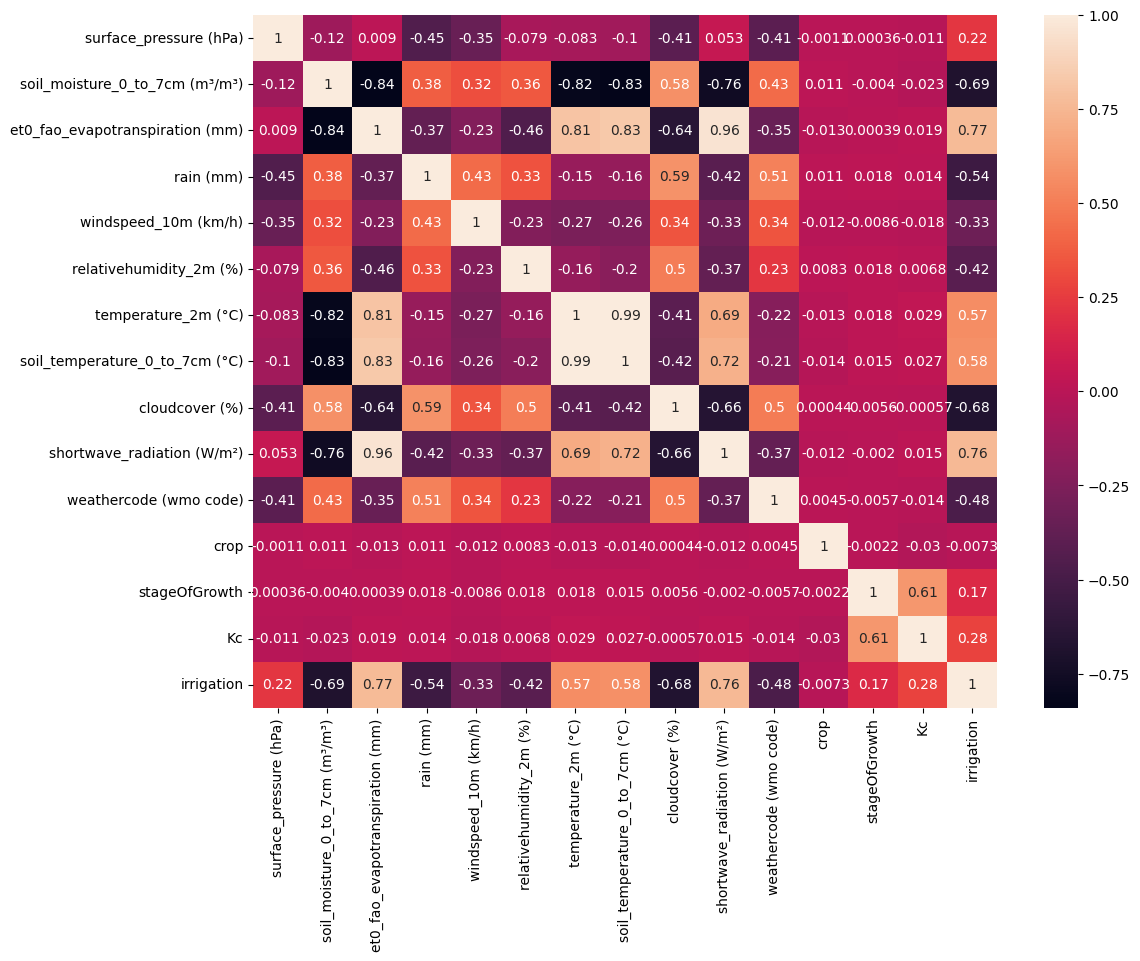

In [32]:
corrmatrix = irrigazione.corr()
#aumentare la dimensione della figura
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, annot=True)

In [33]:
#crop ha una correlazione di 0.0049 quindi conviene eliminarla
irrigazione = irrigazione.drop("crop", axis=1)
#stage of growth ha una correlazione di 0.17 quindi conviene eliminarla
irrigazione = irrigazione.drop("stageOfGrowth",axis = 1)
#surface_pressure (hPa) ha una correlazione di 0.24 quindi conviene eliminarla
irrigazione = irrigazione.drop("surface_pressure (hPa)", axis = 1)
#Kc ha una correlazione di 0.28, tuttavia è una variabile importante per il nostro modello, dato che indica quanta acqua è in grado di trattenere la coltura, quindi non la eliminiamo

La matrice di corrispondenza ora avrà questo aspetto

<AxesSubplot: >

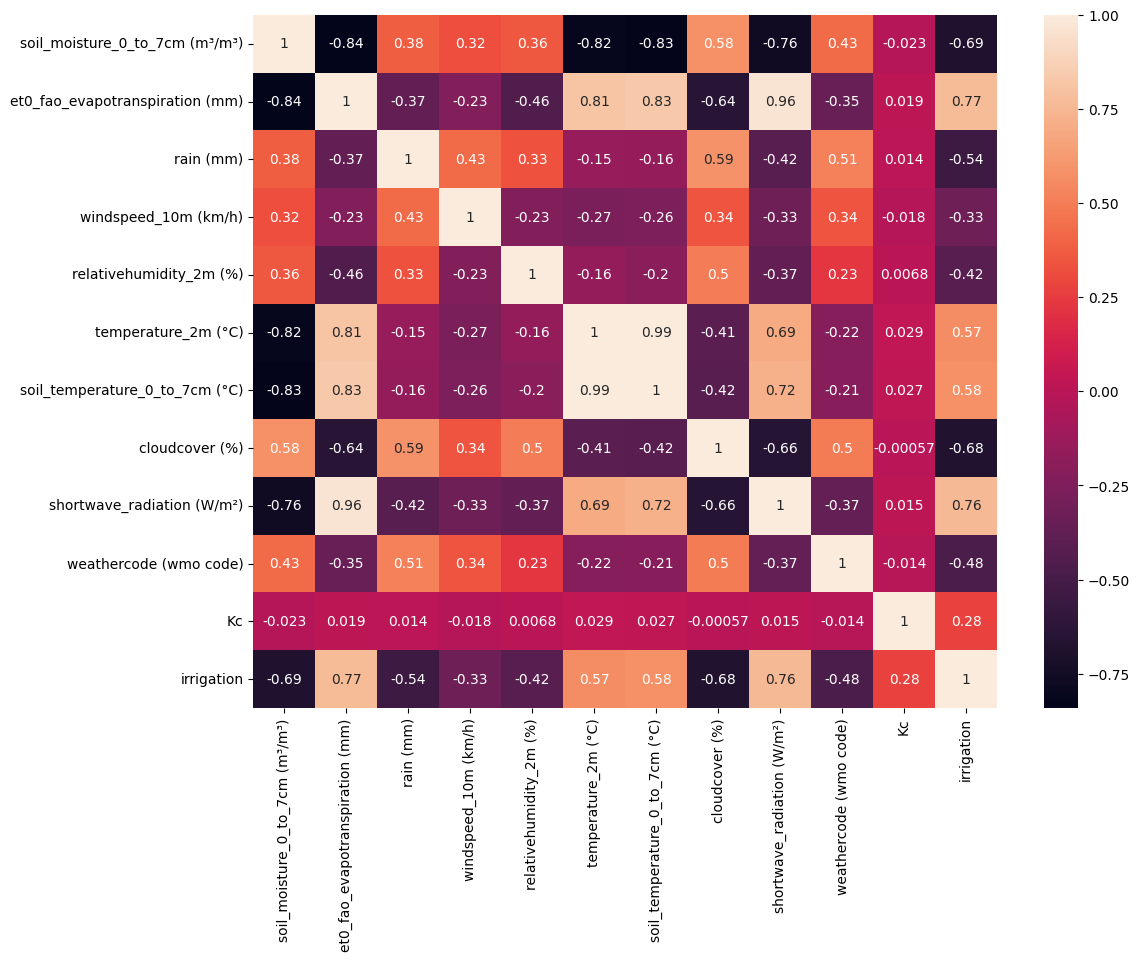

In [34]:
corrmatrix = irrigazione.corr()
#aumentare la dimensione della figura
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, annot=True)

è convenitente eliminare i dati ridondanti e quelli che hanno una particolare corrispondenza con gli altri, elimineremo gli attributi che hanno un coefficiente di correlazione con altri attributi superiore o uguale a 0.6

In [35]:
#temperature_2m (°C) ha una correlazione di 0.99 con soil_temperature (°C) quindi conviene eliminarla, visto che
#soil_temperature (°C) ha una correlazione più alta con la variabile da predire
irrigazione = irrigazione.drop("temperature_2m (°C)", axis = 1)
#stesso discorso per soil_moisture e evapotranspiration
irrigazione = irrigazione.drop("soil_moisture_0_to_7cm (m³/m³)", axis = 1)
#stesso discorso per temperature_2m (°C) e evapotranspiration
irrigazione = irrigazione.drop("soil_temperature_0_to_7cm (°C)", axis = 1)
#stesso discordo per shortwave_radiation (W/m²) e evapotranspiration
irrigazione = irrigazione.drop("shortwave_radiation (W/m²)", axis = 1)
#stesso discordo per cloud_cover (%) e evapotranspiration
irrigazione = irrigazione.drop("cloudcover (%)", axis = 1)

La matrice di corrispondenza ora avrà questo aspetto

<AxesSubplot: >

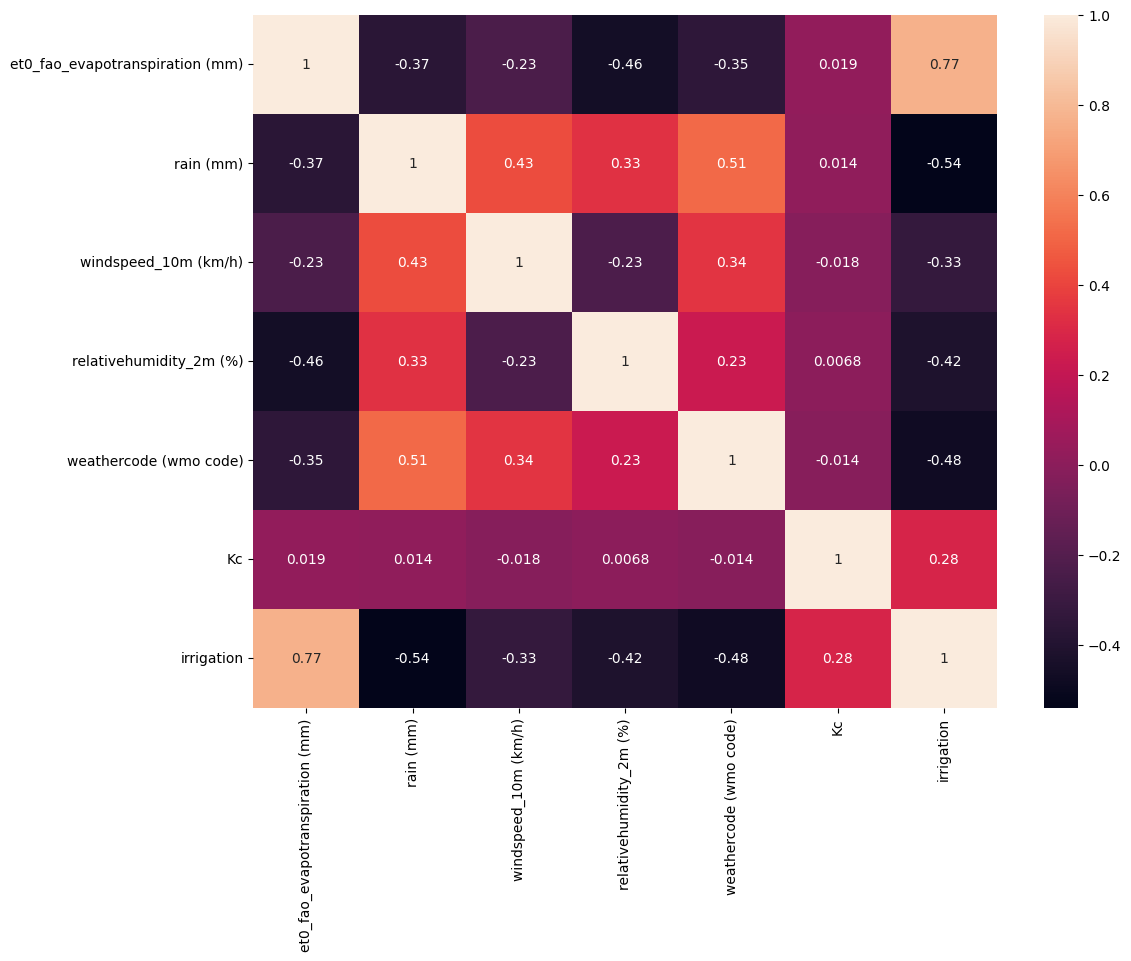

In [36]:
corrmatrix = irrigazione.corr()
#aumentare la dimensione della figura
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, annot=True)

Bilanciamento Dati

<AxesSubplot: xlabel='irrigation', ylabel='count'>

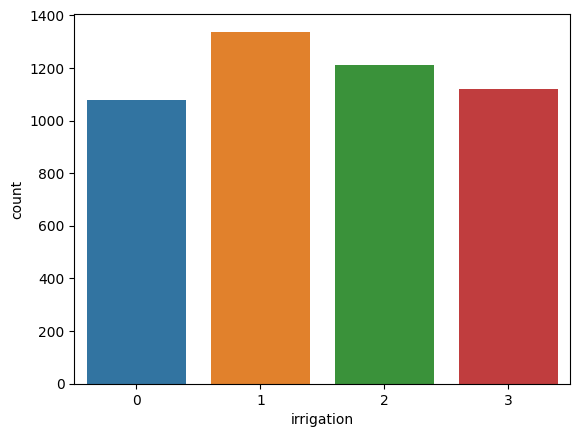

In [37]:
#La variabile categorica ha questi valori
sns.countplot(x='irrigation', data=irrigazione)

Tutto sommato il dataset è bilanciato 

Split Test and Train Data


In [38]:
irrigazione_X = irrigazione.drop('irrigation', axis=1)
irrigazione_y = irrigazione['irrigation']

In [76]:
#Applichiamo una normalizzazione ai dati
normalizer = StandardScaler()
transformer = normalizer.fit(irrigazione_X)
irrigazione_X_normalized = transformer.transform(irrigazione_X)
irr_X_train, irr_X_test, irr_y_train, irr_y_test = train_test_split(irrigazione_X_normalized, irrigazione_y, test_size=0.2)

In [58]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(irr_X_train, irr_y_train)
pred_clf = tree_clf.predict(irr_X_test)
print(classification_report(irr_y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       207
           1       0.96      0.96      0.96       267
           2       0.97      0.96      0.96       250
           3       0.97      0.99      0.98       226

    accuracy                           0.97       950
   macro avg       0.97      0.97      0.97       950
weighted avg       0.97      0.97      0.97       950



In [41]:
#Numero di foglie dell'albero
print("Il numero di foglie generato dal classificatore è : " + str(tree_clf.get_n_leaves()))

Il numero di foglie generato dal classificatore è : 98


è inoltre interessante visualizzare graficamente l'albero

[Text(0.606508875739645, 0.9615384615384616, 'rain (mm) <= -0.082\ngini = 0.748\nsamples = 3799\nvalue = [872, 1071, 960, 896]\nclass = Bassa'),
 Text(0.2948717948717949, 0.8846153846153846, 'et0_fao_evapotranspiration (mm) <= -0.431\ngini = 0.668\nsamples = 2904\nvalue = [13, 1042, 954, 895]\nclass = Bassa'),
 Text(0.11439842209072978, 0.8076923076923077, 'Kc <= 0.453\ngini = 0.253\nsamples = 951\nvalue = [12, 812, 127, 0]\nclass = Bassa'),
 Text(0.07100591715976332, 0.7307692307692307, 'rain (mm) <= -0.095\ngini = 0.077\nsamples = 631\nvalue = [11, 606, 14, 0]\nclass = Bassa'),
 Text(0.0631163708086785, 0.6538461538461539, 'et0_fao_evapotranspiration (mm) <= -0.539\ngini = 0.062\nsamples = 626\nvalue = [6, 606, 14, 0]\nclass = Bassa'),
 Text(0.03944773175542406, 0.5769230769230769, 'rain (mm) <= -0.159\ngini = 0.024\nsamples = 576\nvalue = [6, 569, 1, 0]\nclass = Bassa'),
 Text(0.015779092702169626, 0.5, 'et0_fao_evapotranspiration (mm) <= -0.571\ngini = 0.004\nsamples = 555\nvalue =

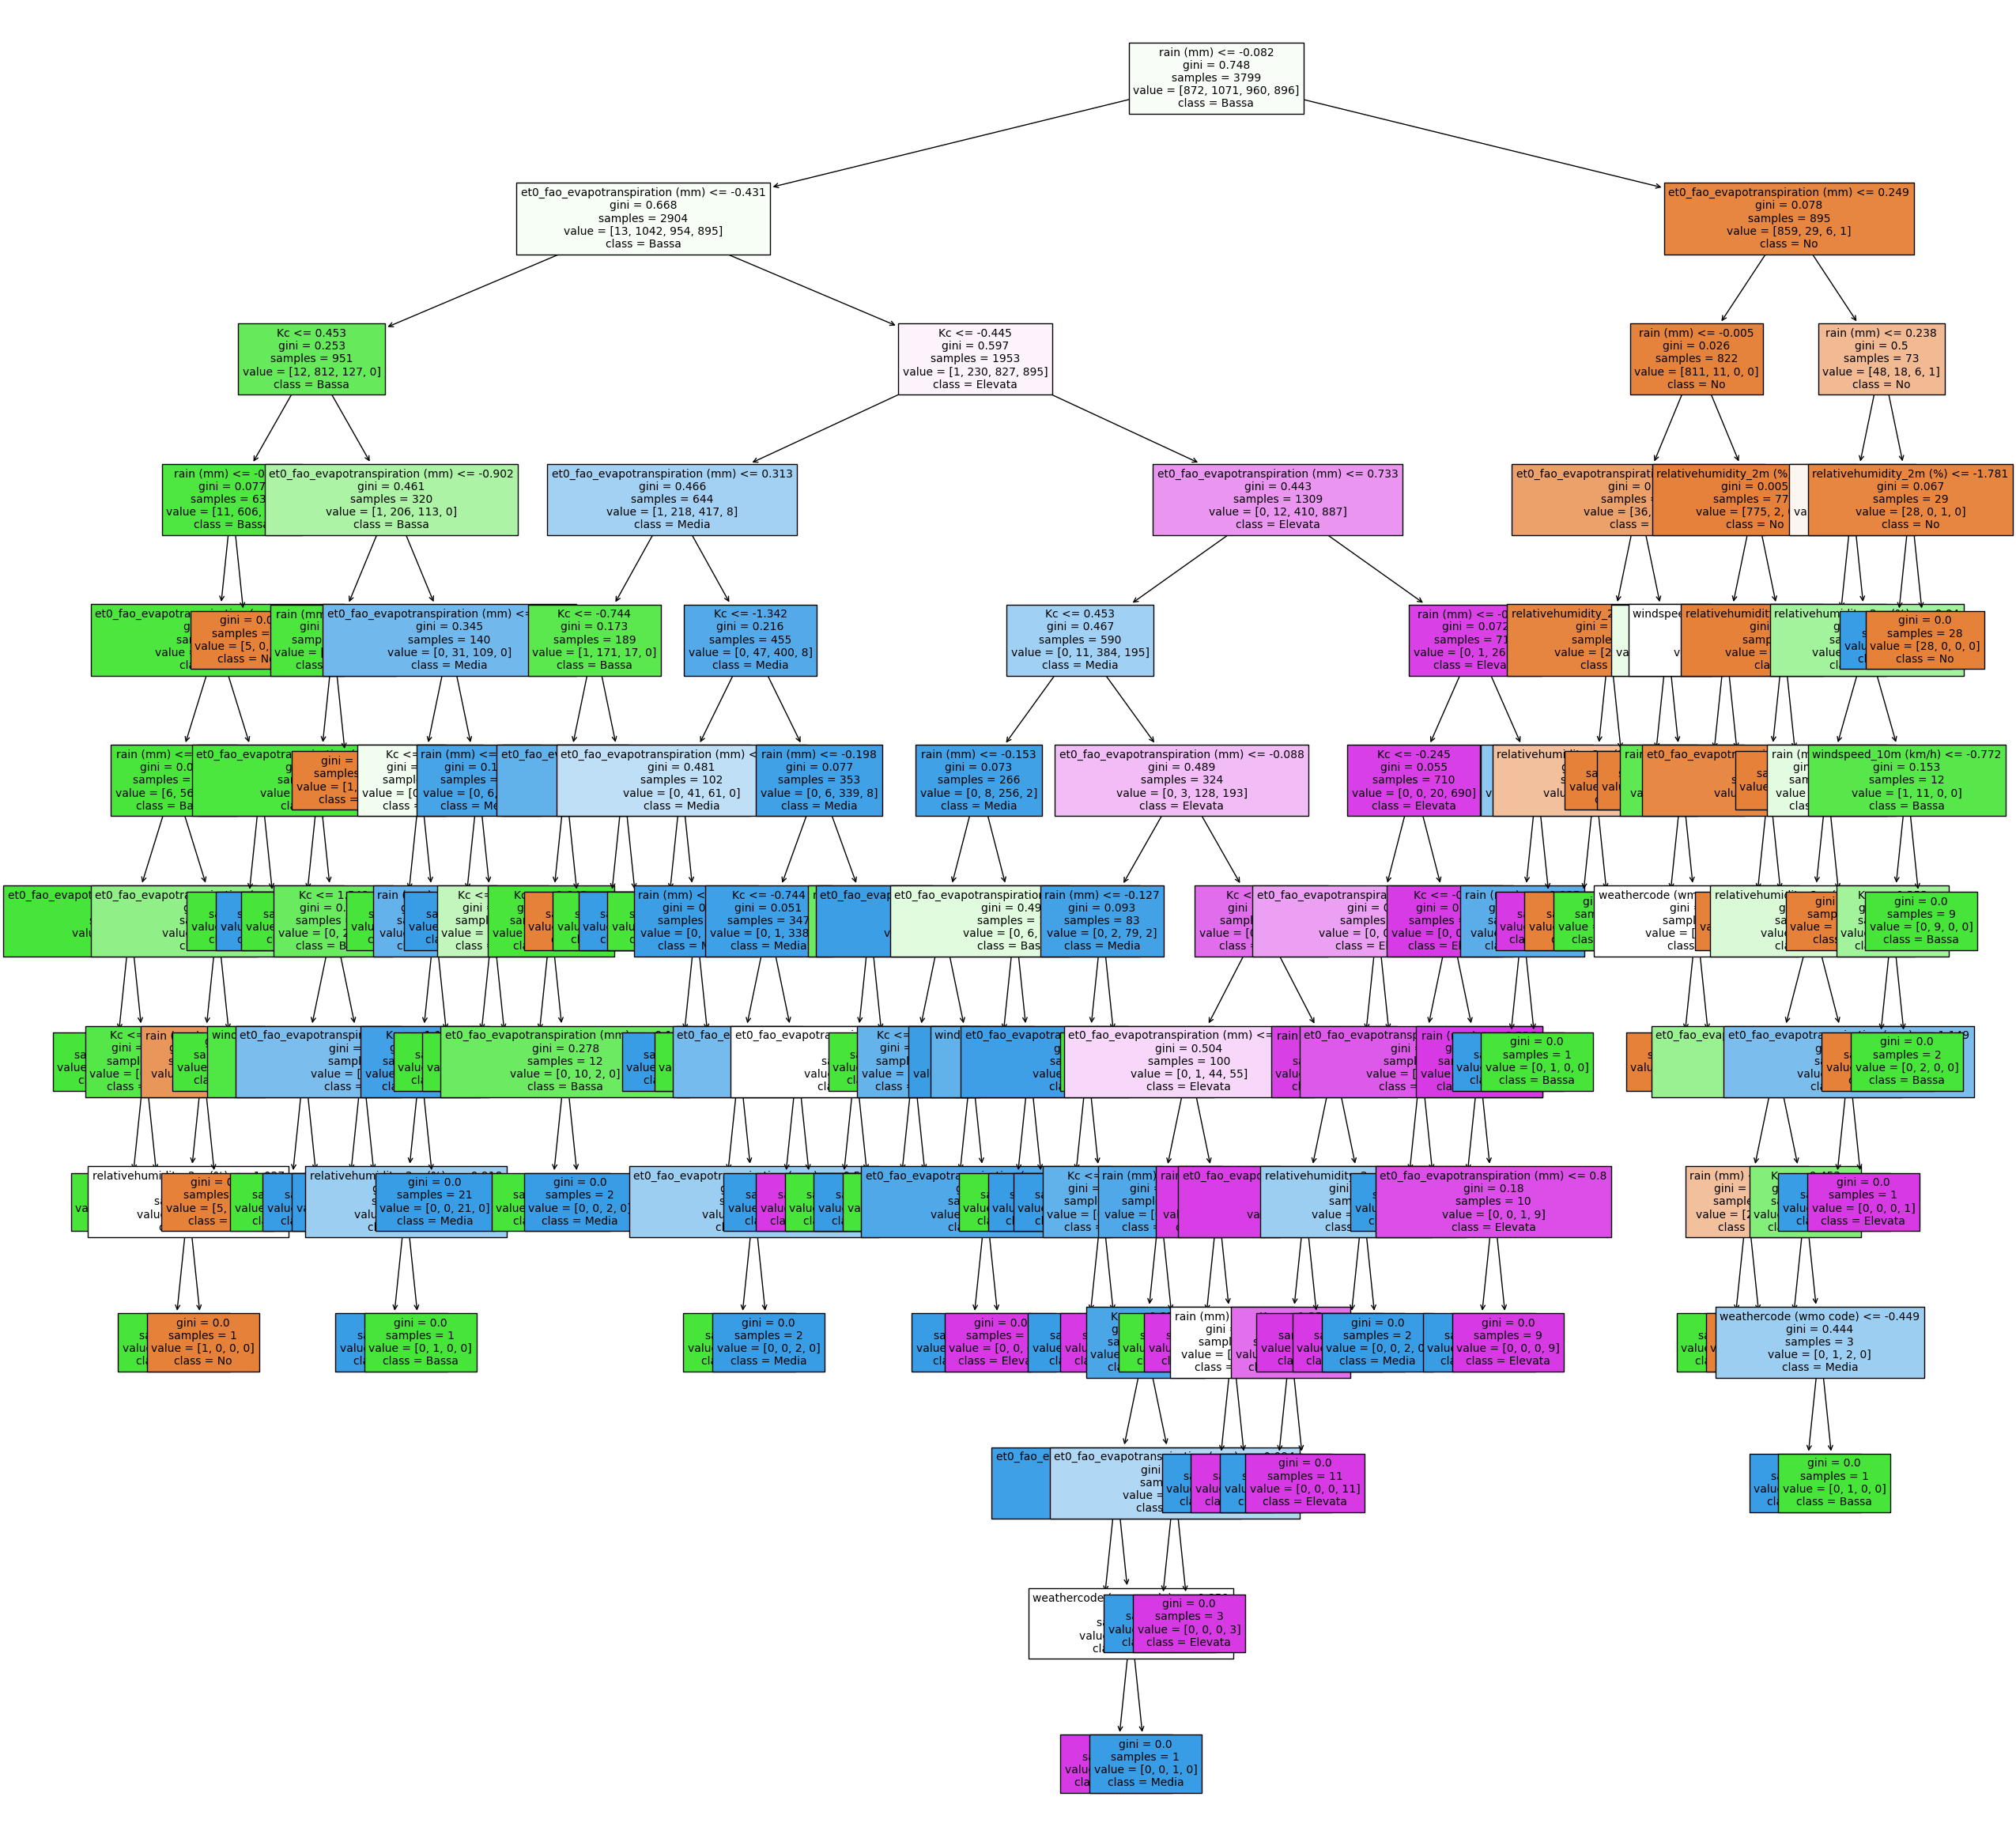

In [59]:
#plotta l'albero di decisione
plt.figure(figsize=(30,30))
tree.plot_tree(tree_clf, filled=True, fontsize=10, class_names=["No", "Bassa", "Media", "Elevata"], feature_names=irrigazione_X.columns)

In [77]:
bayes_clf = GaussianNB()
bayes_clf.fit(irr_X_train, irr_y_train)
pred_clf = bayes_clf.predict(irr_X_test)
print(classification_report(irr_y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       208
           1       0.80      0.74      0.77       257
           2       0.77      0.73      0.75       235
           3       0.94      0.92      0.93       250

    accuracy                           0.83       950
   macro avg       0.83      0.84      0.83       950
weighted avg       0.83      0.83      0.83       950



In [60]:
forest_clf = RandomForestClassifier()
forest_clf.fit(irr_X_train, irr_y_train)
pred_clf = forest_clf.predict(irr_X_test)
print(classification_report(irr_y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       207
           1       0.96      0.95      0.95       267
           2       0.96      0.95      0.96       250
           3       0.98      0.99      0.98       226

    accuracy                           0.97       950
   macro avg       0.97      0.97      0.97       950
weighted avg       0.97      0.97      0.97       950

